Preconditioning map built from GLOW

In [3]:
import matplotlib.pyplot as plt
import argparse
import os
import time

import torch
import torch.optim as optim

import lib.layers as layers
import lib.toy_data as toy_data
import lib.utils as utils
from lib.visualize_flow import visualize_transform

from train_misc import standard_normal_logprob
from train_misc import count_parameters

import numpy as np



In [2]:

SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']
parser = argparse.ArgumentParser('Continuous Normalizing Flow')
parser.add_argument(
    '--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'],
    type=str, default='pinwheel'
)

parser.add_argument('--depth', help='number of coupling layers', type=int, default=10)
parser.add_argument('--glow', type=eval, choices=[True, False], default=False)
parser.add_argument('--nf', type=eval, choices=[True, False], default=False)
  
parser.add_argument('--niters', type=int, default=100001)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--test_batch_size', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--weight_decay', type=float, default=0)

# Track quantities
parser.add_argument('--l1int', type=float, default=None, help="int_t ||f||_1")
parser.add_argument('--l2int', type=float, default=None, help="int_t ||f||_2")
parser.add_argument('--dl2int', type=float, default=None, help="int_t ||f^T df/dt||_2")
parser.add_argument('--JFrobint', type=float, default=None, help="int_t ||df/dx||_F")
parser.add_argument('--JdiagFrobint', type=float, default=None, help="int_t ||df_i/dx_i||_F")
parser.add_argument('--JoffdiagFrobint', type=float, default=None, help="int_t ||df/dx - df_i/dx_i||_F")

parser.add_argument('--save', type=str, default='experiments/cnf')
parser.add_argument('--viz_freq', type=int, default=1000)
parser.add_argument('--val_freq', type=int, default=1000)
parser.add_argument('--log_freq', type=int, default=100)
parser.add_argument('--gpu', type=int, default=0)

_StoreAction(option_strings=['--gpu'], dest='gpu', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [3]:
args = parser.parse_args('')
args.data = 'moons'
args.glow = True
args.save = 'experiments/glow/moonsdepth1'
args.depth = 1


In [4]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

def construct_model():

    if args.nf:
        chain = []
        for i in range(args.depth):
            chain.append(layers.PlanarFlow(2))
        return layers.SequentialFlow(chain)
    else:
        chain = []
        for i in range(args.depth):
            if args.glow: chain.append(layers.BruteForceLayer(2))
            chain.append(layers.CouplingLayer(2, swap=i % 2 == 0))
        return layers.SequentialFlow(chain)


def get_transforms(model):

    if args.nf:
        sample_fn = None
    else:

        def sample_fn(z, logpz=None):
            if logpz is not None:
                return model(z, logpz, reverse=True)
            else:
                return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn


# Standard KL loss/maximum likelihood
def compute_loss(args, model, batch_size=None):
    if batch_size is None: batch_size = args.batch_size

    # load data
    x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss


In [5]:
import torch.nn as nn
import torch.linalg as tla

# args.lr = args.lr/2

model = construct_model().to(device)
optimizer = optim.Adamax(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
time_meter = utils.RunningAverageMeter(0.98)
loss_meter = utils.RunningAverageMeter(0.98)
end = time.time()
best_loss = float('inf')
model.train()

# args.batch_size = 200
for itr in range(1, args.niters + 1):
    
    samples_train = torch.tensor(toy_data.inf_train_gen(args.data, batch_size=args.batch_size)).to(dtype=torch.float32) 
   
    optimizer.zero_grad()
    loss = compute_loss(args, model)
    loss_meter.update(loss.item())
    loss.backward()
    optimizer.step()
    time_meter.update(time.time() - end)

    # if itr % args.log_freq == 0:
    #     log_message = (
    #         'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f})'.format(
    #             itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg
    #         )
    #     )
    #     logger.info(log_message)
    print(loss)
    if itr % args.val_freq == 0 or itr == args.niters:
        with torch.no_grad():
            model.eval()
            test_loss = compute_loss(args, model, batch_size=args.test_batch_size)
            # log_message = '[TEST] Iter {:04d} | Test Loss {:.6f}'.format(itr, test_loss)
            # logger.info(log_message)

            if test_loss.item() < best_loss:
                best_loss = test_loss.item()
                utils.makedirs(args.save)
                torch.save({
                    'args': args,
                    'state_dict': model.state_dict(),
                }, os.path.join(args.save, 'checkpt.pth'))
            model.train()

    if itr % args.viz_freq == 0:
        with torch.no_grad():
            model.eval()
            p_samples = toy_data.inf_train_gen(args.data, batch_size=2000)

            sample_fn, density_fn = get_transforms(model)

            plt.figure(figsize=(9, 3))
            visualize_transform(
                p_samples, torch.randn, standard_normal_logprob, transform=sample_fn, inverse_transform=density_fn,
                samples=True, npts=800, device=device
            )
            fig_filename = os.path.join(args.save, 'figs', '{:04d}.jpg'.format(itr))
            utils.makedirs(os.path.dirname(fig_filename))
            plt.savefig(fig_filename)
            plt.close()


            pushforward_samps = model(torch.tensor(p_samples).to(dtype=torch.float32),None,reverse = False).detach().numpy()
            plt.clf()
            plt.grid(False)
            plt.scatter(pushforward_samps[:,0],pushforward_samps[:,1],s = 0.1)
            plt.axis('square')
            fig_filename_pushforward = os.path.join(args.save,'figs','pushforward{:04d}.jpg'.format(itr))
            plt.savefig(fig_filename_pushforward)
            plt.close

            model.train()
    end = time.time()




tensor(13.8146, grad_fn=<NegBackward0>)
tensor(13.7027, grad_fn=<NegBackward0>)
tensor(13.7477, grad_fn=<NegBackward0>)
tensor(13.7448, grad_fn=<NegBackward0>)
tensor(13.8506, grad_fn=<NegBackward0>)
tensor(13.7497, grad_fn=<NegBackward0>)
tensor(13.6124, grad_fn=<NegBackward0>)
tensor(13.7094, grad_fn=<NegBackward0>)
tensor(13.6259, grad_fn=<NegBackward0>)
tensor(13.6564, grad_fn=<NegBackward0>)
tensor(13.6111, grad_fn=<NegBackward0>)
tensor(13.5854, grad_fn=<NegBackward0>)
tensor(13.6597, grad_fn=<NegBackward0>)
tensor(13.4851, grad_fn=<NegBackward0>)
tensor(13.4653, grad_fn=<NegBackward0>)
tensor(13.4435, grad_fn=<NegBackward0>)
tensor(13.4654, grad_fn=<NegBackward0>)
tensor(13.4135, grad_fn=<NegBackward0>)
tensor(13.4255, grad_fn=<NegBackward0>)
tensor(13.4161, grad_fn=<NegBackward0>)
tensor(13.5181, grad_fn=<NegBackward0>)
tensor(13.5980, grad_fn=<NegBackward0>)
tensor(13.2519, grad_fn=<NegBackward0>)
tensor(13.2364, grad_fn=<NegBackward0>)
tensor(13.3218, grad_fn=<NegBackward0>)


In [ ]:
torch.save(model,'moons_model_depth2_larger_lessnoise')
# checkpoint = torch.load('8gaussians10/checkpt.pth')

# model = construct_model().to(device)
# checkpoint['state_dict']
# model.load_state_dict(checkpoint['state_dict'])



Simple score-based generative modeling examples

In [52]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data

import numpy as np

In [64]:
# model = torch.load('moons_model_depth2_larger_lessnoise')
model = torch.load('8gaussians_model_depth3')

In [144]:
# Adding a bespoke activation function

# class complexexpo(nn.Module):
#     def __init__(self,weights = 1):
#         super().__init__()
#         self.weights = weights

#     def forward(self,input): 
#         exponent = torch.complex(torch.tensor(0,dtype = torch.float32),torch.tensor(self.weights * input))
#         evaluation = torch.exp(exponent)
#         return evaluation
        

class cosineact(nn.Module):
    def __init__(self,weights = 1):
        super().__init__()
        self.weights = weights

    def forward(self,input):
        evaluation = torch.cos(self.weights * input)
        return evaluation
    

class cosineact_fixedt(nn.Module):
    def __init__(self,weights = 1):
        super().__init__()
        self.weights = weights

    def forward(self,input):
        evaluation = torch.cos(self.weights * input)
        return evaluation
    

    
# Random Fourier features
B = 2 * torch.pi *torch.randn(2,32)
c = 2 * torch.pi * torch.rand(1,32)



In [167]:
#Initialize score model


hidden_units = 32
scorenet = nn.Sequential(
        nn.Linear(3, hidden_units),
        cosineact(),
        # nn.Linear(hidden_units, hidden_units),
        # nn.Softplus(),
        # nn.Linear(hidden_units, hidden_units),
        # nn.Softplus(),
        nn.Linear(hidden_units, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, 2),
    )


# learning_rate = 1e-3
# batch_size = 100

# from torch import nn

# class DenoisingModel(nn.Module):
    
#     def __init__(self, hidden_units=32):
#         super(DenoisingModel, self).__init__()
#         # hidden_units = 32
        
#         # data and timestep
#         self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc1.weight)
#         self.activation1 = nn.GELU()
#         self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc2.weight)
#         self.activation2 = nn.GELU()
#         self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
#         nn.init.xavier_uniform_(self.fc3.weight)
#         self.activation3 = nn.GELU()
        
#         self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc4.weight)
#         self.activation4 = nn.GELU()
#         self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc5.weight)
#         self.activation5 = nn.GELU()
#         self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
#         nn.init.xavier_uniform_(self.fc6.weight)
#         self.activation6 = nn.GELU()
        
#         self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc7.weight)
#         self.activation7 = nn.GELU()
#         self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
#         nn.init.xavier_uniform_(self.fc8.weight)
#         self.activation8 = nn.GELU()
#         self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
#         nn.init.xavier_uniform_(self.fc9.weight)
        
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.activation1(x)
#         x = self.fc2(x)
#         x = self.activation2(x)
#         x = self.fc3(x)
#         x = self.activation3(x)
#         x = self.fc4(x)
#         x = self.activation4(x)
#         x = self.fc5(x)
#         x = self.activation5(x)
#         x = self.fc6(x)
#         x = self.activation6(x)
#         x = self.fc7(x)
#         x = self.activation7(x)
#         x = self.fc8(x)
#         x = self.activation8(x)
#         x = self.fc9(x)
        
#         return x
      
# scorenet = DenoisingModel()
# print(scorenet)

optimizer = optim.Adam(scorenet.parameters(), lr=0.001)

In [168]:
# Loss function
def time_dsm_score_estimator(scorenet,samples,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin


    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise
    target = - 1/ (sigmas ** 2) * (noise)
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)

def FF_time_dsm_score_estimator(scorenet,samples,Tmin,Tmax,eps,B,c):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin


    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise
    target = - 1/ (sigmas ** 2) * (noise)

    FFperturbed_samples = torch.matmul(perturbed_samples,B) + c
    # perturbed_samples = torch.cat( (torch.cos(FFperturbed_samples), torch.sin(FFperturbed_samples)),1 )

    perturbed_samples = torch.cos(FFperturbed_samples)

    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)

# Loss function
def deterministic_time_dsm_score_estimator(scorenet,samples,t):

    # t = torch.rand(samples.shape[0]) * (T - eps) + eps
    # t = torch.linspace(eps,T,int(T/eps))
    loss = 0
    for ii in range(len(t)-1):

        sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
        # sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
        noise = torch.randn_like(samples) * sigmas
        perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise
        target = - 1/ (sigmas ** 2) * (noise)
        score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
        scores = scorenet(score_eval_samples)

        target = target.view(target.shape[0],-1)
        scores = scores.view(scores.shape[0],-1)
        loss_vec = 0.5 * ((scores-target) ** 2).sum(dim = -1) 
        loss = loss + (t[ii+1]-t[ii])*loss_vec.mean(dim = 0)

    return loss


In [169]:
# Training 

# optimizer = optim.Adam(scorenet.parameters(), lr = 0.001)

T = 0.5
# eps = 0.01
# t =torch.cat((torch.linspace(0.005,0.2,int(0.2/0.005+1)),torch.linspace(0.2+0.01,T+0.01,int((T-0.2)/0.01+1))),0)
# t = torch.linspace(0.005,0.1,int(0.1/0.005) + 1)
epochs = 100000
for step in range(epochs):
    p_samples = toy_data.inf_train_gen('8gaussians', batch_size = 256)
    samples = torch.tensor(p_samples).to(dtype = torch.float32)
    samples = model(samples,None,reverse=False)

    samples1 = samples[0:128:]
    samples2 = samples[128:-1,:]


    # loss = deterministic_time_dsm_score_estimator(scorenet,samples,t) + time_dsm_score_estimator(scorenet,samples,0.1,T,0.01)
    loss = time_dsm_score_estimator(scorenet,samples1,0,0.02,0.0001) + time_dsm_score_estimator(scorenet,samples2,0.02,T,0.0001)
    # loss = FF_time_dsm_score_estimator(scorenet,samples1,0,0.02,0.0001,B,c) + FF_time_dsm_score_estimator(scorenet,samples2,0.02,T,0.0001,B,c)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if not step%100:
        print(loss,step)




tensor(227.1591, grad_fn=<AddBackward0>) 0
tensor(339.3042, grad_fn=<AddBackward0>) 100
tensor(187.9935, grad_fn=<AddBackward0>) 200
tensor(230.0478, grad_fn=<AddBackward0>) 300
tensor(257.3015, grad_fn=<AddBackward0>) 400
tensor(232.5952, grad_fn=<AddBackward0>) 500
tensor(337.2810, grad_fn=<AddBackward0>) 600
tensor(241.1116, grad_fn=<AddBackward0>) 700
tensor(252.4329, grad_fn=<AddBackward0>) 800
tensor(194.8770, grad_fn=<AddBackward0>) 900
tensor(249.0269, grad_fn=<AddBackward0>) 1000
tensor(226.1880, grad_fn=<AddBackward0>) 1100
tensor(324.5812, grad_fn=<AddBackward0>) 1200
tensor(327.7363, grad_fn=<AddBackward0>) 1300
tensor(183.5135, grad_fn=<AddBackward0>) 1400
tensor(496.5464, grad_fn=<AddBackward0>) 1500
tensor(308.8293, grad_fn=<AddBackward0>) 1600
tensor(260.6021, grad_fn=<AddBackward0>) 1700
tensor(270.3784, grad_fn=<AddBackward0>) 1800
tensor(248.0495, grad_fn=<AddBackward0>) 1900
tensor(284.1891, grad_fn=<AddBackward0>) 2000
tensor(243.6604, grad_fn=<AddBackward0>) 2100


In [170]:
p_samples = toy_data.inf_train_gen('8gaussians', batch_size = 2048)
samples = torch.tensor(p_samples).to(dtype = torch.float32)
samples = model(samples,None,reverse=False).detach().numpy()
plt.clf()
plt.scatter(samples[:,0],samples[:,1],s = 0.1)

# plt.xlim([-4, 4])
# plt.ylim([-3, 3])

plt.savefig('training_samps')



In [179]:
def ou_dynamics(init, T):
    init = init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)
    return init

def reverse_sde(score, init,T,lr=0.001/2):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init


def FF_reverse_sde(score, init,T,B,c,lr=0.001):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr


        FFinit = torch.matmul(init,B) + c
        FFinit = torch.cos(FFinit)
        # FFinit = torch.cat( (torch.cos(FFinit), torch.sin(FFinit)),1 )
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(FFinit.shape[0],1),FFinit),1)


        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def reverse_sde_sensitive(score, init,t0,T,lr=0.005):
    step = int(T/lr) 
    for i in range(step,int(t0/lr),-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)

    lr = lr/10
    for i in range(int(t0/lr)-1,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(current_lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def reverse_ode_flow(score,init,T,lr = 0.005):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach() )
    return init

def FF_reverse_ode_flow(score,init,T,B,c,lr = 0.005):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr

        FFinit = torch.matmul(init,B) + c
        FFinit = torch.cos(FFinit)

        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(FFinit.shape[0],1),FFinit),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach() )
    return init

In [180]:
p_samples = toy_data.inf_train_gen('8gaussians', batch_size = 10000)
samples = torch.tensor(p_samples).to(dtype = torch.float32)
samples = model(samples,None, reverse = False)
samples = ou_dynamics(samples,torch.tensor(0.0)).detach().numpy()
plt.clf()

# bleh = torch.randn((10000,2)).detach().numpy()
plt.scatter(samples[:,0],samples[:,1],s = 0.1)
# plt.scatter(bleh[:,0],bleh[:,1],s = 0.1)
plt.axis('square')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

plt.savefig('pushforward_8gaussians_depth3')

In [181]:
samples_lang = torch.randn(10000, 2) # * (right_bound - left_bound) + left_bound
samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(T)).detach().numpy()
# samples_lang = reverse_sde_sensitive(scorenet, samples_lang,torch.tensor(0.01),torch.tensor(T)).detach().numpy()
# samples_lang = FF_reverse_sde(scorenet, samples_lang,torch.tensor(T),B,c).detach().numpy()

samples = torch.tensor(toy_data.inf_train_gen('8gaussians', batch_size = 10000))
samples = model(samples.to(dtype = torch.float32),None,reverse = False)
samples_lang_noisedtraining = samples * torch.exp(-0.5 * torch.tensor(T)) + torch.sqrt(1-torch.exp(-torch.tensor(T))) * torch.randn_like(samples)
samples_lang_noisedtraining = reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T)).detach().numpy()
# samples_lang_noisedtraining = FF_reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T),B,c).detach().numpy()


samples_lang_deterministic = torch.randn(10000,2)
# samples_lang_deterministic = FF_reverse_ode_flow(scorenet,samples_lang_deterministic,torch.tensor(T),B,c).detach().numpy()
samples_lang_deterministic = reverse_ode_flow(scorenet,samples_lang_deterministic,torch.tensor(T)).detach().numpy()

In [182]:
plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
# plt.xlim([-16, 16])
# plt.ylim([-16, 16])
plt.axis('square')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.savefig('FFtrain2_shallow2_pushforward_8gaussians_depth3')

# samples_lang = torch.tensor(samples_lang) 
samples_target = model(torch.tensor(samples_lang),None,reverse = True)

samples_target = samples_target.detach().numpy()
plt.clf()
plt.scatter(samples_target[:,0],samples_target[:,1],s = 0.1)
plt.axis('square')
plt.xlim([-16, 16])
plt.ylim([-16, 16])
plt.savefig('FFtrain2_shallow2_target_8gaussians_depth3_reversesde')




samples_target_deterministic = model(torch.tensor(samples_lang_deterministic),None,reverse = True)
samples_target_deterministic = samples_target_deterministic.detach().numpy()

plt.clf()
plt.scatter(samples_target_deterministic[:,0],samples_target_deterministic[:,1],s = 0.1)
plt.savefig('FFtrain2_shallow2_target_8gaussians_depth3_deterministic')





samples_target_noisedtraining = model(torch.tensor(samples_lang_noisedtraining),None,reverse = True)

samples_target_noisedtraining = samples_target_noisedtraining.detach().numpy()
plt.clf()
plt.scatter(samples_target_noisedtraining[:,0],samples_target_noisedtraining[:,1],s = 0.1)
plt.axis('square')
plt.xlim([-16, 16])
plt.ylim([-16, 16])
plt.savefig('FFtrain2_shallow2_target_8gaussians_depth3_noisedtraining')



samples_glowonly = model(torch.randn((10000,2)),None,reverse = True)
samples_glowonly = samples_glowonly.detach().numpy()
plt.clf()
plt.scatter(samples_glowonly[:,0],samples_glowonly[:,1],s = 0.1)
plt.axis('square')
plt.xlim([-16, 16])
plt.ylim([-16, 16])
plt.savefig('target_glowonly_8gaussians_depth3')




In [22]:
torch.save('score_checkerboard_final','scorenet')


Density evolution figures

In [2]:
model = torch.load('checkerboard_precondition/checkerboard_depth2')


# p_samples = toy_data.inf_train_gen('moons', batch_size = 10000)
# samples = torch.tensor(p_samples).to(dtype = torch.float32)
# samples = model(samples,None, reverse = False)
# samples = ou_dynamics(samples,torch.tensor(0.005)).detach().numpy()
# plt.clf()

# # bleh = torch.randn((10000,2)).detach().numpy()
# plt.scatter(samples[:,0],samples[:,1],s = 0.1)
# # plt.scatter(bleh[:,0],bleh[:,1],s = 0.1)
# plt.axis('square')
# plt.xlim([-4, 4])
# plt.ylim([-4, 4])

# plt.savefig('pushforward_moons_depth2_large_lessnoise')


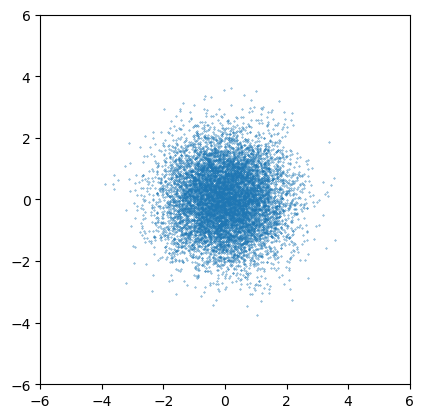

In [6]:
samples = toy_data.inf_train_gen('checkerboard',batch_size = 10000)
samples = torch.tensor(samples).to(dtype = torch.float32)

samples = ou_dynamics(samples,torch.tensor(10)).detach().numpy()

plt.clf()
plt.axis('square')
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.scatter(samples[:,0],samples[:,1],s = 0.1)
plt.show()

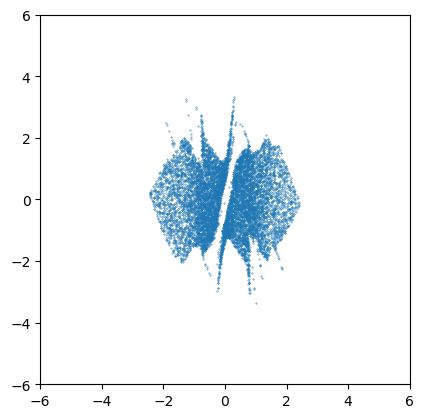

In [15]:
samples = toy_data.inf_train_gen('checkerboard',batch_size = 10000)
samples = model(torch.tensor(samples).to(dtype = torch.float32),None,reverse = False)

samples = ou_dynamics(samples,torch.tensor(0)).detach().numpy()

plt.clf()
plt.axis('square')
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.scatter(samples[:,0],samples[:,1],s = 0.1)
plt.savefig('noising_pushforward_checkerboard')

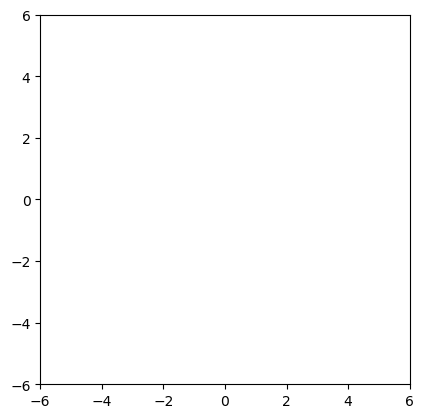

In [31]:
fig,axs = plt.subplots(2,7)

# for jj in range(6):
    samples = toy_data.inf_train_gen('checkerboard',batch_size = 10000)
    samples = torch.tensor(samples).to(dtype = torch.float32)

    samples = ou_dynamics(samples,torch.tensor(0.1*jj)).detach().numpy()

    plt.clf()
    plt.axis('square')
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])
    axs[0,jj].scatter(samples[:,0],samples[:,1],s = 0.1)
    # axs[0,0].scatter(samples[:,0],samples[:,1],s = 0.1)

plt.show()